# Background
Physiological and laboratory data provided in collaboration with MIT’s GOSSIS community initiative (e.g., blood pressure, heart rate, glucose levels, lactate levels) collected in the first 24 hours of ICU admission are critical indicators of a patient’s condition.

# Objective

To accurate predict the mortality in the 1st 24 hrs following admission to an Intensive Care Unit (ICU).

# Research Quesiton

1) To determine whether deep learning models can effectively predict ICU mortality using these early indicators and Identify which features are most influential in the prediction.
2) How does model performance compare to traditional clinical scoring systems (apache_4a_hospital_death_prob, apache_4a_icu_death_prob) for ICU mortality prediction?

# Dataset
The dataset contains records collected over the course of a year from over 91,000 intensive care unit (ICU) visits at various hospitals.
It has 91,713 records and 186 columns.

Target variable : hospital_death

### Import Necessary Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

#Use this if you are running the code on Colab
from google.colab import files
import io

uploaded = files.upload()

In [ ]:
source_df = pd.read_csv('./dataset/raw/Datathon #3 Dataset - HAD7001.csv')
print(source_df.shape)
dict_df = pd.read_csv('./dataset/raw/Datathon #3 Data Dictionary - HAD7001.csv')
dict_df.Category.value_counts()

(91713, 186)


Category
labs                         60
vitals                       52
APACHE covariate             28
demographic                  16
labs blood gas               16
APACHE comorbidity            8
identifier                    3
APACHE prediction             2
APACHE grouping               2
GOSSIS example prediction     1
Name: count, dtype: int64

In [ ]:
def plot_roc_curves(result, title):
    plt.figure(figsize=(6, 4))
    for name, metrics in result.items():
        print(name)
        if "ROC AUC" in metrics and "FPR" in metrics and "TPR" in metrics:
            fpr = np.array(metrics["FPR"])
            tpr = np.array(metrics["TPR"])
            roc_auc = metrics["ROC AUC"]
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def print_classification_report(model_results):
    for model_name, metrics in model_results.items():
        # Extract metrics
        accuracy = metrics['Accuracy']
        precision_0 = metrics['Precision (Survived 0)']
        recall_0 = metrics['Recall (Survived 0)']
        f1_0 = metrics['F1-score (Survived 0)']
        precision_1 = metrics['Precision (Death 1)']
        recall_1 = metrics['Recall (Death 1)']
        f1_1 = metrics['F1-score (Death 1)']
        cm = metrics['Confusion Matrix']

        support_0 = cm[0][0] + cm[0][1]
        support_1 = cm[1][0] + cm[1][1]
        total_support = support_0 + support_1

        macro_precision = (precision_0 + precision_1) / 2
        macro_recall = (recall_0 + recall_1) / 2
        macro_f1 = (f1_0 + f1_1) / 2

        weighted_precision = (precision_0 * support_0 + precision_1 * support_1) / total_support
        weighted_recall = (recall_0 * support_0 + recall_1 * support_1) / total_support
        weighted_f1 = (f1_0 * support_0 + f1_1 * support_1) / total_support

        print(f"\n{model_name}")
        print("              precision    recall    f1-score    support")
        print(f"\nSurvived (0)      {precision_0:.2f}       {recall_0:.2f}       {f1_0:.2f}      {support_0}")
        print(f"   Death (1)      {precision_1:.2f}       {recall_1:.2f}       {f1_1:.2f}       {support_1}")
        print(f"\n    accuracy                           {accuracy:.2f}      {total_support}")
        print(f"   macro avg      {macro_precision:.2f}       {macro_recall:.2f}       {macro_f1:.2f}      {total_support}")
        print(f"weighted avg      {weighted_precision:.2f}       {weighted_recall:.2f}       {weighted_f1:.2f}      {total_support}")


## Select factors based on Domain knowledge

In [ ]:
demographics = ['age', 'bmi', 'ethnicity', 'gender', 'weight', 'height']
coma = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache']
admission = ['hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'pre_icu_los_days', 'readmission_status']
ventilation = ['ventilated_apache', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min']
ldh = ['d1_lactate_max', 'd1_lactate_min']
renal_failure = ['hepatic_failure', 'arf_apache']
apache_noscore = ['albumin_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache',
                  'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache',
                  'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
                  'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache',
                  'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache',
                  'urineoutput_apache', 'ventilated_apache', 'wbc_apache']
### KEEP it later for benchmark
benchmark_var = ['apache_4a_hospital_death_prob']
# KeyError: "['hematrocrit_apache', 'apace_post_operative'] not in index"
#icu_vars = ['ventilated_apache, intubated_apache, apache_post_operative']
target_var = 'hospital_death'

In [ ]:
sel_variables = list(set([target_var] + demographics + coma + admission + ventilation + ldh + renal_failure + apache_noscore))
print('{}  of varaibles are selected'.format(len(sel_variables)))

44  of varaibles are selected


In [ ]:
p_record_counts = source_df["patient_id"].value_counts()
p_records = p_record_counts[p_record_counts > 1]
print("Find patients with more than one record", len(p_records))

p_hospital_counts = source_df.groupby("patient_id")["hospital_id"].nunique()
patients_multiple_hospitals = p_hospital_counts[p_hospital_counts > 1]

p_encounter_counts = source_df.groupby("patient_id")["encounter_id"].nunique()
p_encounters = p_encounter_counts[p_encounter_counts > 1]

p_icu_counts = source_df.groupby("patient_id")["icu_id"].nunique()
p_icu_counters = p_icu_counts[p_icu_counts > 1]

print('Check if patient_id has stayed in more than one hospitals', len(patients_multiple_hospitals))
print("patient_id has more than one encounter", len(p_encounters))
print("patient_id has more than one icu admission", len(p_icu_counters))

Find patients with more than one record 0
Check if patient_id has stayed in more than one hospitals 0
patient_id has more than one encounter 0
patient_id has more than one icu admission 0


In [ ]:
#source_df.drop(columns=['encounter_id','patient_id','hospital_id' ,'icu_id'] , axis=1, inplace=True)
source_df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
df = source_df.copy()

#source_df = df.copy()

In [ ]:
source_df  = source_df[sel_variables]

### EDA for feature inspection

In [ ]:
# Drop columns with a single unique value
single_value_cols = [col for col in source_df.columns if source_df[col].nunique() == 1]
source_df.drop(columns=single_value_cols, inplace=True)
print('Drop columns with a single unique value')
print(single_value_cols )

Drop columns with a single unique value
['readmission_status']


In [ ]:
# Convert columns with less than 10 unique values to categorical type
low_unique_cols = [col for col in source_df.columns if source_df[col].nunique() <= 10]
source_df[low_unique_cols] = source_df[low_unique_cols].astype('category')
print('convert them into categorical', low_unique_cols)
print(len(low_unique_cols))

convert them into categorical ['hospital_death', 'arf_apache', 'gcs_motor_apache', 'icu_admit_source', 'gcs_eyes_apache', 'gender', 'gcs_unable_apache', 'intubated_apache', 'ethnicity', 'gcs_verbal_apache', 'hepatic_failure', 'icu_stay_type', 'ventilated_apache']
13


In [ ]:
numerical_vars = source_df.select_dtypes(include=["number"]).columns.tolist()
categorical_vars = source_df.select_dtypes(exclude=["number"]).columns.tolist()
dataset_overview = {
    "Total Rows": source_df.shape[0],
    "Total Columns": source_df.shape[1],
    "Duplicate Rows": source_df.duplicated().sum(),
    "Numerical Column Counts": len(numerical_vars),
    "Categorical Column counts": len(categorical_vars)
}
dataset_overview

{'Total Rows': 91713,
 'Total Columns': 43,
 'Duplicate Rows': np.int64(0),
 'Numerical Column Counts': 29,
 'Categorical Column counts': 14}

In [ ]:
negative_values = source_df[numerical_vars] <0
negative_perc = negative_values.sum()/len(source_df) * 100
display(negative_perc)
# drop the columns with negative values
source_df = source_df.drop(columns=negative_perc[negative_perc > 80].index)

albumin_apache         0.000000
paco2_apache           0.000000
age                    0.000000
sodium_apache          0.000000
paco2_for_ph_apache    0.000000
resprate_apache        0.000000
creatinine_apache      0.000000
bun_apache             0.000000
d1_spo2_max            0.000000
bmi                    0.000000
glucose_apache         0.000000
d1_resprate_min        0.000000
pao2_apache            0.000000
fio2_apache            0.000000
weight                 0.000000
d1_lactate_min         0.000000
pre_icu_los_days       0.848298
d1_spo2_min            0.000000
wbc_apache             0.000000
temp_apache            0.000000
height                 0.000000
urineoutput_apache     0.000000
d1_lactate_max         0.000000
hematocrit_apache      0.000000
map_apache             0.000000
bilirubin_apache       0.000000
ph_apache              0.000000
d1_resprate_max        0.000000
heart_rate_apache      0.000000
dtype: float64

In [ ]:
description = source_df.describe()
description

,albumin_apache,paco2_apache,age,sodium_apache,paco2_for_ph_apache,resprate_apache,creatinine_apache,bun_apache,d1_spo2_max,bmi,...,temp_apache,height,urineoutput_apache,d1_lactate_max,hematocrit_apache,map_apache,bilirubin_apache,ph_apache,d1_resprate_max,heart_rate_apache
count,37334.000000,20845.000000,87485.000000,73113.000000,20845.000000,90479.000000,72860.000000,72451.00000,91380.000000,88284.000000,...,87605.000000,90379.000000,42715.000000,23317.000000,71835.000000,90719.000000,33579.000000,20845.000000,91328.000000,90835.000000
mean,2.902968,42.183238,62.309516,137.966373,42.183238,25.811007,1.480014,25.82533,99.241836,29.185818,...,36.414472,169.641588,1738.276831,2.927383,32.988739,88.015873,1.147721,7.353895,28.882774,99.707932
std,0.681863,12.382412,16.775119,5.279418,12.382412,15.106312,1.525787,20.67298,1.794181,8.275142,...,0.833496,10.795378,1448.162411,3.075982,6.873585,42.032412,2.165538,0.097755,10.701973,30.870502
min,1.200000,18.000000,16.000000,117.000000,18.000000,4.000000,0.300000,4.00000,0.000000,14.844926,...,32.100000,137.200000,0.000000,0.400000,16.200000,40.000000,0.100000,6.960540,14.000000,30.000000
25%,2.400000,34.400000,52.000000,135.000000,34.400000,11.000000,0.720000,13.00000,99.000000,23.641975,...,36.200000,162.500000,740.361600,1.200000,28.000000,54.000000,0.400000,7.308000,22.000000,86.000000
50%,2.900000,40.000000,65.000000,138.000000,40.000000,28.000000,0.980000,19.00000,100.000000,27.654655,...,36.500000,170.100000,1386.201600,1.900000,33.200000,67.000000,0.600000,7.360000,26.000000,104.000000
75%,3.400000,47.000000,75.000000,141.000000,47.000000,36.000000,1.530000,32.00000,100.000000,32.930206,...,36.700000,177.800000,2324.548800,3.300000,37.900000,125.000000,1.100000,7.419000,32.000000,120.000000
max,4.600000,95.000000,89.000000,158.000000,95.000000,60.000000,11.180000,127.00000,100.000000,67.814990,...,39.700000,195.590000,8716.669632,19.800000,51.400000,200.000000,51.000000,7.590000,92.000000,178.000000


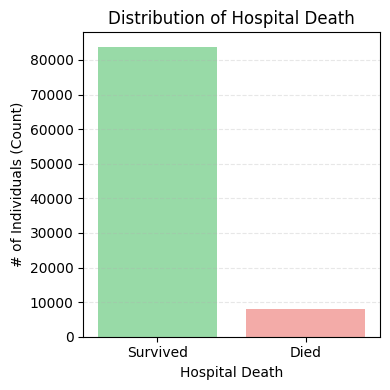

In [ ]:
c = sns.color_palette("pastel")
target_var = 'hospital_death'
value_counts = source_df[target_var].value_counts()
category_order = [0, 1]  # If 0 is for 'Died' and 1 is for 'Survived'
category_labels = ['Survived', 'Died']
category_colors = [c[2], c[3]]

plt.figure(figsize=(4, 4))
sns.barplot(x=category_order, y=value_counts[category_order].values, palette=category_colors)

plt.title("Distribution of Hospital Death")
plt.ylabel('# of Individuals (Count)')
plt.xlabel("Hospital Death")
plt.xticks(ticks=category_order, labels=category_labels)  # Set custom labels on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


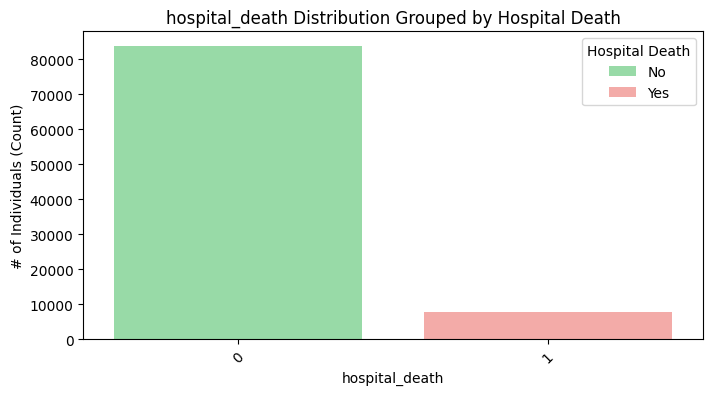

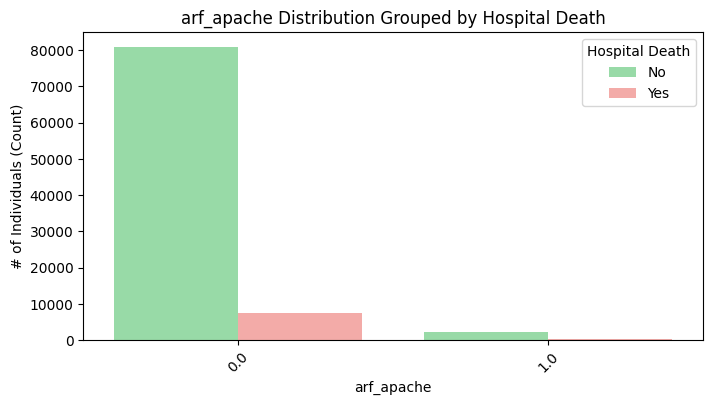

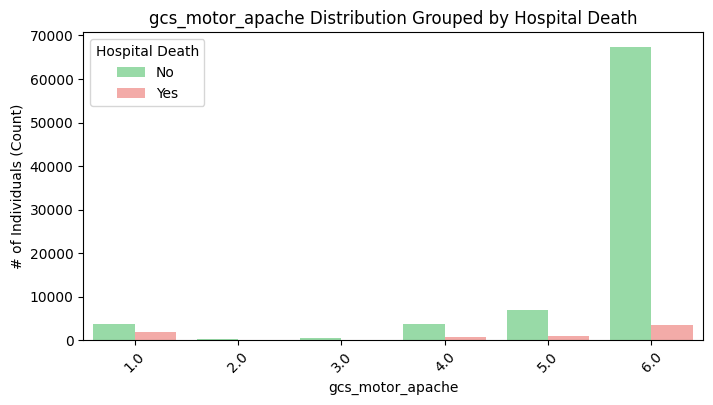

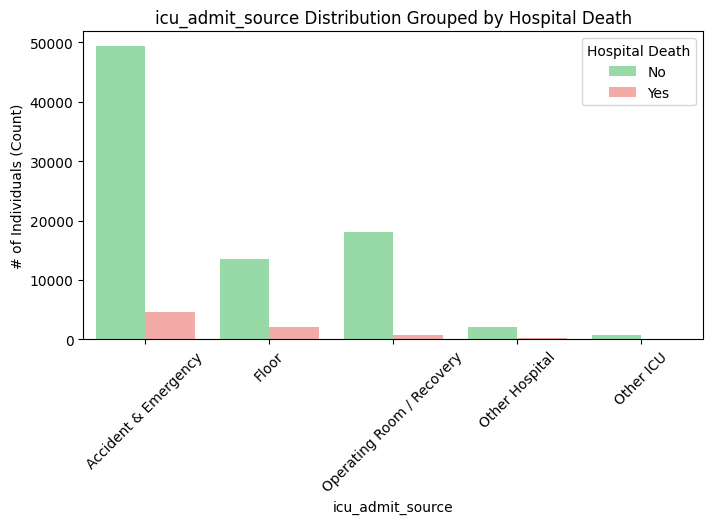

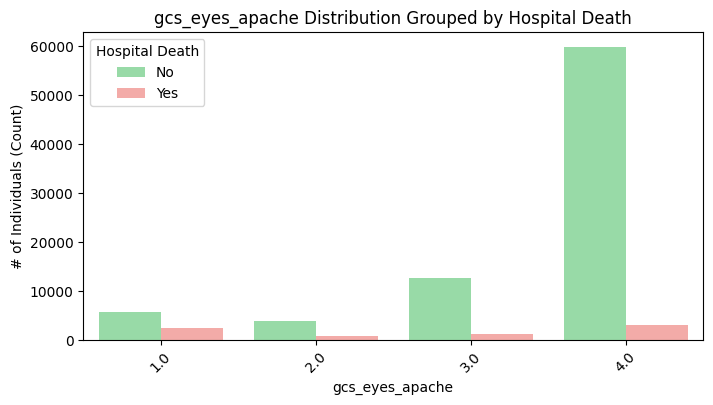

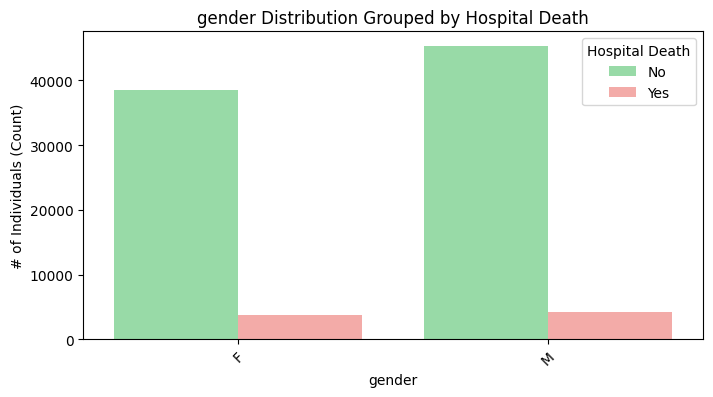

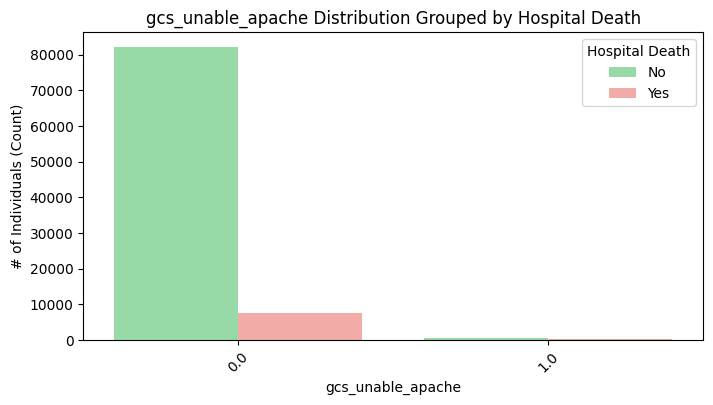

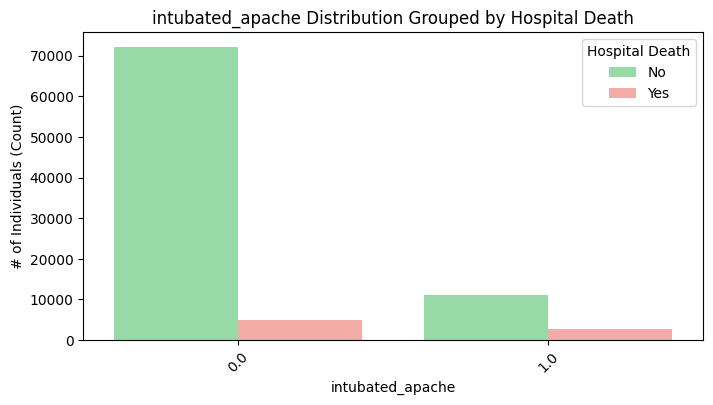

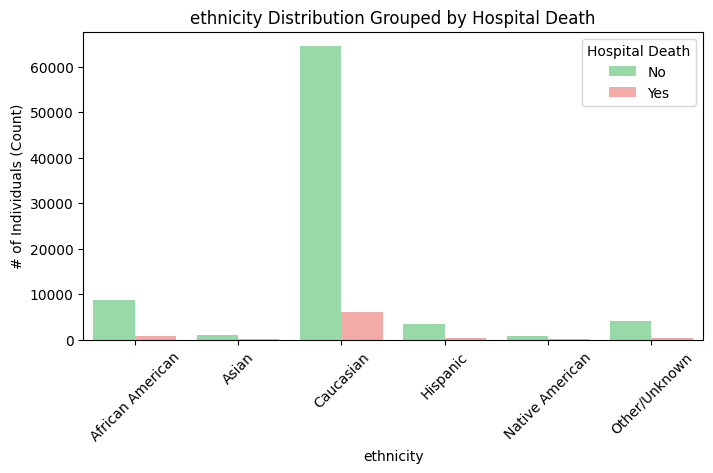

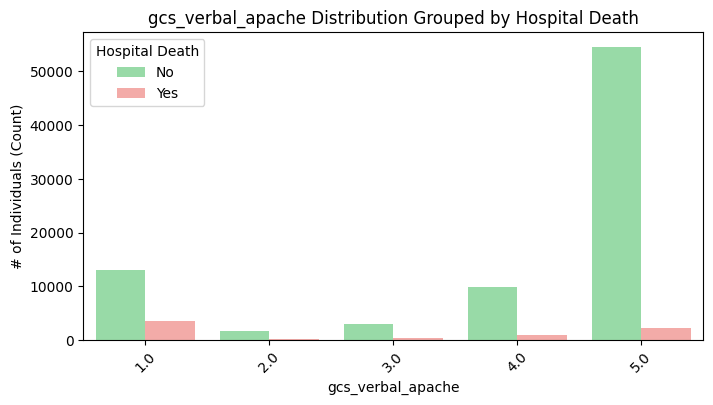

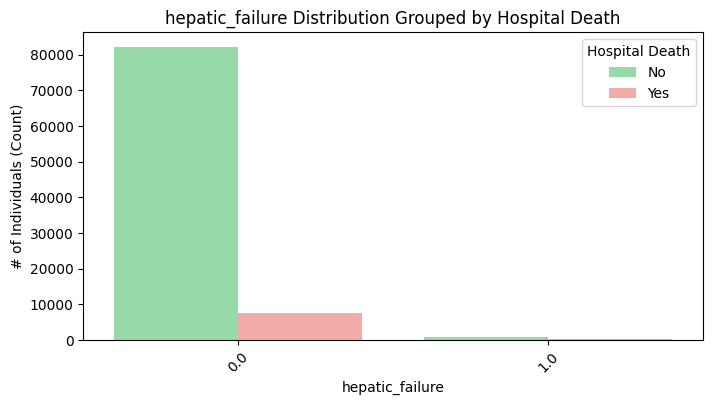

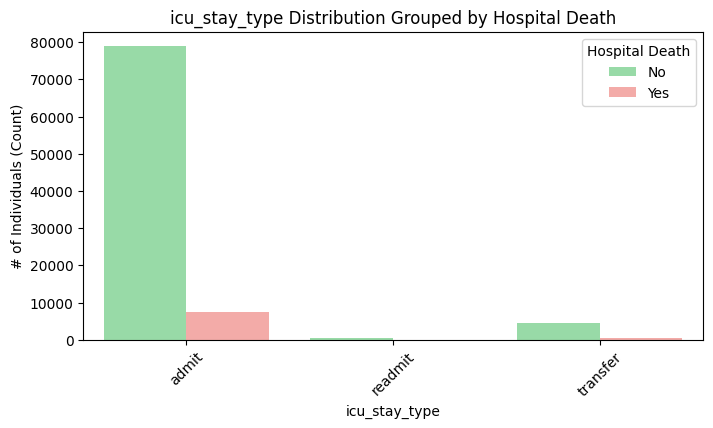

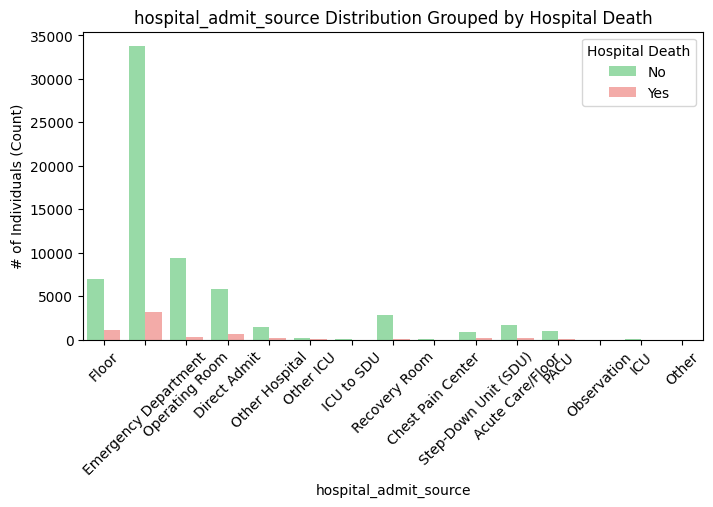

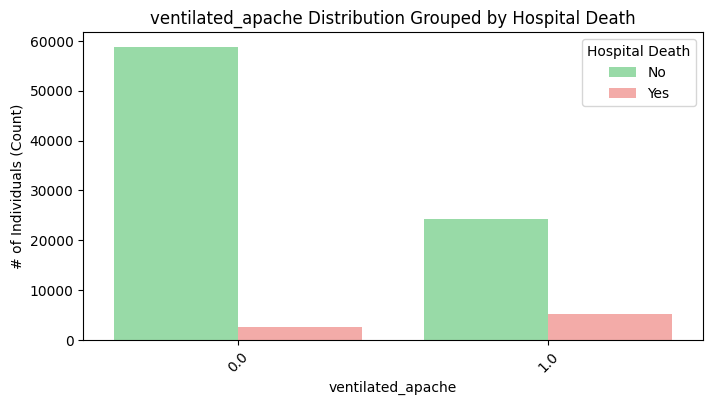

In [ ]:
for feature in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=source_df, x=feature, hue=target_var, palette=category_colors)
    plt.title(f'{feature} Distribution Grouped by Hospital Death')
    plt.xlabel(feature)
    plt.ylabel('# of Individuals (Count)')
    plt.xticks(rotation=45)
    plt.legend(title='Hospital Death', labels=['No', 'Yes'])
    plt.show()

In [ ]:
categorical_vars

['hospital_death',
 'arf_apache',
 'gcs_motor_apache',
 'icu_admit_source',
 'gcs_eyes_apache',
 'gender',
 'gcs_unable_apache',
 'intubated_apache',
 'ethnicity',
 'gcs_verbal_apache',
 'hepatic_failure',
 'icu_stay_type',
 'hospital_admit_source',
 'ventilated_apache']

In [ ]:
numerical_vars

['albumin_apache',
 'paco2_apache',
 'age',
 'sodium_apache',
 'paco2_for_ph_apache',
 'resprate_apache',
 'creatinine_apache',
 'bun_apache',
 'd1_spo2_max',
 'bmi',
 'glucose_apache',
 'd1_resprate_min',
 'pao2_apache',
 'fio2_apache',
 'weight',
 'd1_lactate_min',
 'pre_icu_los_days',
 'd1_spo2_min',
 'wbc_apache',
 'temp_apache',
 'height',
 'urineoutput_apache',
 'd1_lactate_max',
 'hematocrit_apache',
 'map_apache',
 'bilirubin_apache',
 'ph_apache',
 'd1_resprate_max',
 'heart_rate_apache']

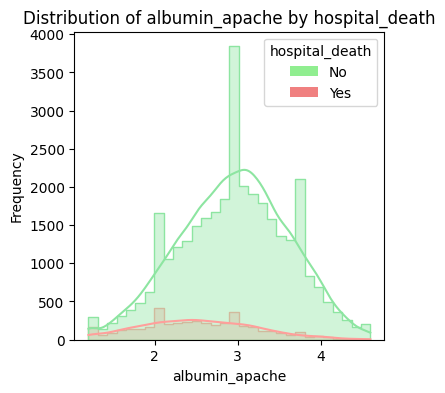

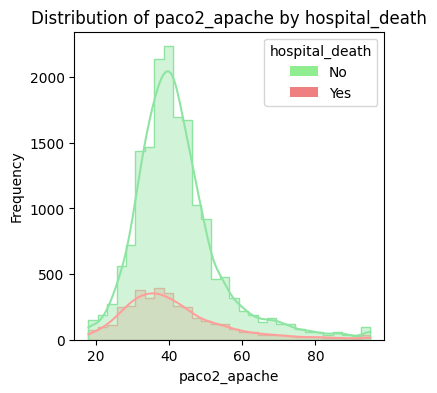

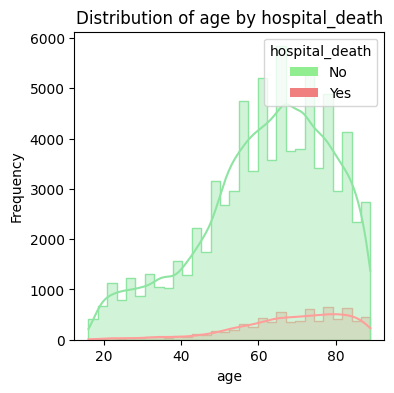

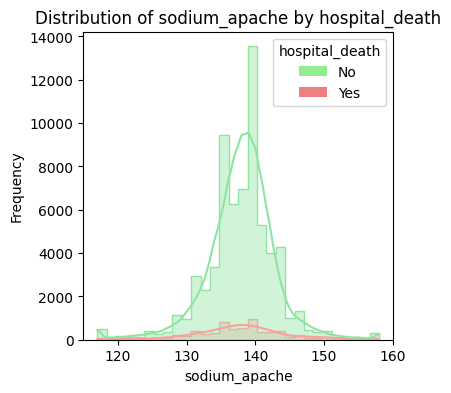

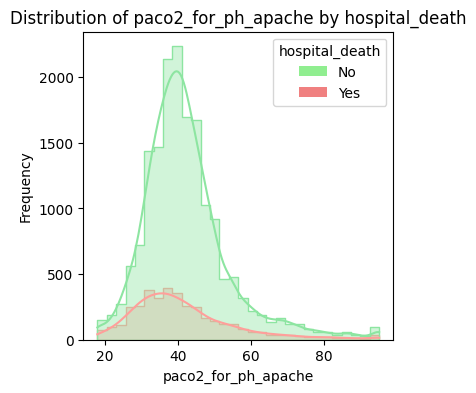

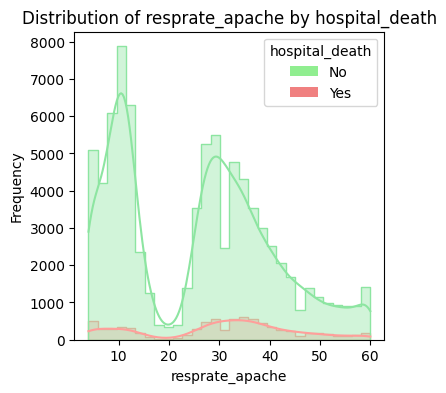

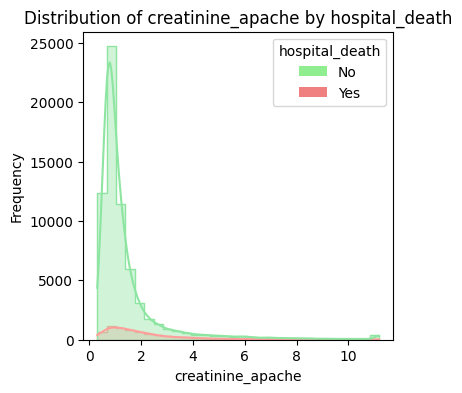

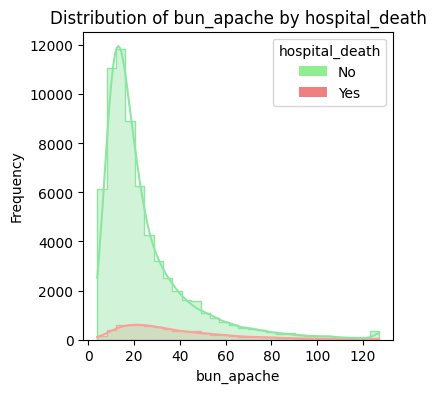

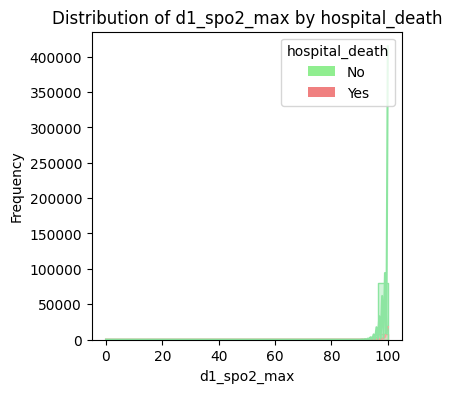

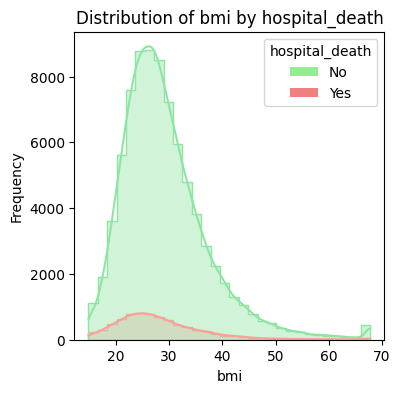

In [ ]:
from matplotlib.patches import Patch

for col in numerical_vars[:10]:
    plt.figure(figsize=(4, 4))
    sns.histplot(data=source_df, x=col, hue=target_var, kde=True, bins=30, palette=category_colors, element='step', alpha=0.4)
    plt.title(f'Distribution of {col} by hospital_death')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    legend_elements = [ Patch(facecolor='lightgreen', label='No'), Patch(facecolor='lightcoral',label='Yes') ]
    plt.legend(handles=legend_elements, title='hospital_death', loc='upper right')
    plt.show()




# Missing Values

### Instead of dropping them, to investigate the missingness pattern
1. Either impute 999 to indicate "Not measure" (Data driven approach)
2. Impute with Median group by conditions <<<=== Need to investigagte further
3. Impute with Multiple Imputation (MICE)

In [ ]:
num_missing = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
missing_num_percent = (source_df[num_missing].isnull().sum() / len(source_df))
missing_num_percent = missing_num_percent.sort_values(ascending=False)
print(missing_num_percent)

paco2_apache           0.772715
paco2_for_ph_apache    0.772715
fio2_apache            0.772715
pao2_apache            0.772715
ph_apache              0.772715
d1_lactate_min         0.745761
d1_lactate_max         0.745761
bilirubin_apache       0.633869
albumin_apache         0.592926
urineoutput_apache     0.534254
wbc_apache             0.240010
hematocrit_apache      0.216741
bun_apache             0.210025
creatinine_apache      0.205565
sodium_apache          0.202807
glucose_apache         0.120332
age                    0.046100
temp_apache            0.044792
bmi                    0.037388
weight                 0.029658
height                 0.014545
resprate_apache        0.013455
map_apache             0.010838
heart_rate_apache      0.009573
d1_resprate_max        0.004198
d1_resprate_min        0.004198
d1_spo2_max            0.003631
d1_spo2_min            0.003631
dtype: float64


In [ ]:
cat_missing = [col for col in categorical_vars if source_df[col].isnull().sum() > 0]
missing_cat_percent = (source_df[cat_missing].isnull().sum() / len(source_df))
missing_cat_percent = missing_cat_percent.sort_values(ascending=False)
print(missing_cat_percent)

hospital_admit_source    0.233435
gcs_motor_apache         0.020728
gcs_verbal_apache        0.020728
gcs_eyes_apache          0.020728
ethnicity                0.015210
gcs_unable_apache        0.011307
hepatic_failure          0.007796
arf_apache               0.007796
ventilated_apache        0.007796
intubated_apache         0.007796
icu_admit_source         0.001221
gender                   0.000273
dtype: float64


In [ ]:
missing_threshold = 0.6

cat_columns_to_drop = missing_cat_percent[missing_cat_percent > missing_threshold].index
num_columns_to_drop = missing_num_percent[missing_num_percent > missing_threshold].index

In [ ]:
num_columns_to_drop

Index(['paco2_apache', 'paco2_for_ph_apache', 'fio2_apache', 'pao2_apache',
       'ph_apache', 'd1_lactate_min', 'd1_lactate_max', 'bilirubin_apache'],
      dtype='object')

=> Imputation may introduce bias if data is not missing at random.

=> Some values may be missing because they weren’t measured due to clinical decisions (e.g., arterial blood gases not taken unless respiratory distress is suspected)


=>  As 'h1' for hourly assessment and 'd1' for daily assessment

=> Even if 70% is missed, retain the 'h' prefix variables

We I will treat it as "not measured" and impute '999'

In [ ]:
# missing_threshold = 0.6
num_columns_to_drop = missing_num_percent[missing_num_percent > missing_threshold]
h1_columns = num_columns_to_drop[num_columns_to_drop.index.str.startswith('h1')].index.tolist()
num_columns_to_drop = num_columns_to_drop[~num_columns_to_drop.index.str.startswith('h1')].index.tolist()
print("Columns to drop:", num_columns_to_drop)
print("Columns to impute:", h1_columns)

Columns to drop: ['paco2_apache', 'paco2_for_ph_apache', 'fio2_apache', 'pao2_apache', 'ph_apache', 'd1_lactate_min', 'd1_lactate_max', 'bilirubin_apache']
Columns to impute: []


In [ ]:
print("Before Dropping Category Missing Values ", source_df.shape[1])
source_df.drop(columns=cat_columns_to_drop, inplace=True)
print("AFter Dropping Category Missing Values",source_df.shape[1])

print("Before Dropping Numerical Missing Values", source_df.shape[1])
source_df.drop(columns=num_columns_to_drop, inplace=True)
print("Imputed columns")
source_df[h1_columns] = source_df[h1_columns].fillna(999)
print("AFter Dropping Numerical Missing Values", source_df.shape[1])

Before Dropping Category Missing Values  43
AFter Dropping Category Missing Values 43
Before Dropping Numerical Missing Values 43
Imputed columns
AFter Dropping Numerical Missing Values 35


###  Impute the rest of the missing values

In [ ]:
numerical_vars = source_df.select_dtypes(include=["number"]).columns.tolist()

num_missing_after = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
d1_h1_columns = [col for col in num_missing_after if col.startswith(('d1_', 'h1_'))]
demo_cols = [col for col in num_missing_after if col not in d1_h1_columns]
print("Columns starting with 'd1_' or 'h1_':", d1_h1_columns)
print("The rest of the variables ':", demo_cols)

# Impute  continuous numerical variables with median values
source_df[d1_h1_columns] = source_df[d1_h1_columns].fillna(999)
for col in demo_cols:
    source_df[col].fillna(source_df[col].median(), inplace=True)

Columns starting with 'd1_' or 'h1_': ['d1_spo2_max', 'd1_resprate_min', 'd1_spo2_min', 'd1_resprate_max']
The rest of the variables ': ['albumin_apache', 'age', 'sodium_apache', 'resprate_apache', 'creatinine_apache', 'bun_apache', 'bmi', 'glucose_apache', 'weight', 'wbc_apache', 'temp_apache', 'height', 'urineoutput_apache', 'hematocrit_apache', 'map_apache', 'heart_rate_apache']


In [ ]:
num_missing = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
print(num_missing)

[]


In [ ]:
print(source_df.shape, df.shape)
source_df['benchmark']  = df[benchmark_var]
print(source_df.shape, df.shape)

(91713, 35) (91713, 186)
(91713, 36) (91713, 186)


### Drop features has correlation score > 70

In [ ]:
eliminate_correlation = True
if eliminate_correlation:
    correlation_threshold = 0.6
    numerical_df = source_df[numerical_vars]
    corr_matrix = numerical_df.corr()
    high_corr_mask = (np.abs(corr_matrix) > correlation_threshold ) & ~np.eye(corr_matrix.shape[0], dtype=bool)
    features_to_drop = set()

    while high_corr_mask.values.any():
        counts = high_corr_mask.sum(axis=0)
        feature_to_drop = counts.idxmax()
        features_to_drop.add(feature_to_drop)
        high_corr_mask.loc[feature_to_drop, :] = False
        high_corr_mask.loc[:, feature_to_drop] = False
    print(features_to_drop)
    #source_df.drop(columns=list(features_to_drop), inplace=True)

{'creatinine_apache', 'd1_resprate_min', 'd1_spo2_max', 'bmi'}


In [ ]:
source_df.shape

(91713, 36)

### Handle missing values in Categorical_vars

In [ ]:
missing_cat_percent

hospital_admit_source    0.233435
gcs_motor_apache         0.020728
gcs_verbal_apache        0.020728
gcs_eyes_apache          0.020728
ethnicity                0.015210
gcs_unable_apache        0.011307
hepatic_failure          0.007796
arf_apache               0.007796
ventilated_apache        0.007796
intubated_apache         0.007796
icu_admit_source         0.001221
gender                   0.000273
dtype: float64

In [ ]:
cat_missing

['arf_apache',
 'gcs_motor_apache',
 'icu_admit_source',
 'gcs_eyes_apache',
 'gender',
 'gcs_unable_apache',
 'intubated_apache',
 'ethnicity',
 'gcs_verbal_apache',
 'hepatic_failure',
 'hospital_admit_source',
 'ventilated_apache']

In [ ]:
# drop it instead of imputing
print("Before dropping category", source_df.shape)
source_df.dropna(subset=[col for col in cat_missing ], inplace=True)
print("After dropping category", source_df.shape)


Before dropping category (91713, 36)
After dropping category (67425, 36)


In [ ]:
for cat in categorical_vars:
    print(source_df[cat] .value_counts())

hospital_death
0    61628
1     5797
Name: count, dtype: int64
arf_apache
0.0    65577
1.0     1848
Name: count, dtype: int64
gcs_motor_apache
6.0    53601
5.0     5919
1.0     4102
4.0     3165
3.0      400
2.0      238
Name: count, dtype: int64
icu_admit_source
Accident & Emergency         39846
Operating Room / Recovery    14419
Floor                        11077
Other Hospital                1626
Other ICU                      457
Name: count, dtype: int64
gcs_eyes_apache
4.0    47522
3.0    10407
1.0     6137
2.0     3359
Name: count, dtype: int64
gender
M    36477
F    30948
Name: count, dtype: int64
gcs_unable_apache
0.0    67425
1.0        0
Name: count, dtype: int64
intubated_apache
0.0    57110
1.0    10315
Name: count, dtype: int64
ethnicity
Caucasian           53802
African American     6803
Hispanic             2886
Other/Unknown        2521
Asian                 791
Native American       622
Name: count, dtype: int64
gcs_verbal_apache
5.0    43290
1.0    12138
4.0     797

In [ ]:
# Drop columns with a single unique value
single_value_cols = [col for col in source_df.columns if source_df[col].nunique() == 1]
source_df.drop(columns=single_value_cols, inplace=True)
print('Drop columns with a single unique value')
print(single_value_cols )

Drop columns with a single unique value
['gcs_unable_apache']


In [ ]:
source_df.head(2)

,hospital_death,arf_apache,albumin_apache,gcs_motor_apache,age,sodium_apache,icu_admit_source,resprate_apache,creatinine_apache,gcs_eyes_apache,...,height,urineoutput_apache,icu_stay_type,hematocrit_apache,map_apache,hospital_admit_source,ventilated_apache,d1_resprate_max,heart_rate_apache,benchmark
0,0,0.0,2.3,6.0,68.0,134.0,Floor,36.0,2.51,3.0,...,180.3,1386.2016,admit,27.4,40.0,Floor,0.0,34.0,118.0,0.10
1,0,0.0,2.9,3.0,77.0,145.0,Floor,33.0,0.56,1.0,...,160.0,1386.2016,admit,36.9,46.0,Floor,1.0,32.0,120.0,0.47


In [ ]:
source_df.to_csv('./dataset/clean_df_sel2.csv', header=False)

# Data Preprocessing : Inspect the levels of categorical variables


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def preprocess_data(source_df, binary_cols, dummy_columns):
    benchmark_df = source_df.pop('benchmark')
    t_df = source_df.copy()

    categorical_missing_cols = [col for col in dummy_columns if col in t_df.columns and t_df[col].isnull().sum() > 0]
    t_df.dropna(subset=categorical_missing_cols, inplace=True)

    h1_d1_cols = [col for col in t_df.columns if col.startswith('h1') or col.startswith('d1')]
    continuous_columns = [col for col in t_df.select_dtypes(include=["number"]).columns
                          if col not in h1_d1_cols + ["hospital_death"]]
    t_df[h1_d1_cols] = t_df[h1_d1_cols].fillna(999)

    for col in continuous_columns:
        t_df[col].fillna(t_df[col].median(), inplace=True)
    if "gender" in t_df.columns:
        t_df["gender"] = t_df["gender"].map({"M": 1, "F": 0}).astype("category")
    if "hospital_admit_source" in t_df.columns:
        rare_categories = t_df["hospital_admit_source"].value_counts()[t_df["hospital_admit_source"].value_counts() < 500].index
        t_df["hospital_admit_source"] = t_df["hospital_admit_source"].replace(rare_categories, "Other/Unknown")

    for col in binary_cols:
        if col in t_df.columns:
            t_df[col] = t_df[col].astype("category")

    t_df = pd.get_dummies(t_df, columns=dummy_columns, drop_first=True, dtype=bool)
    boolean_columns = t_df.select_dtypes(include=['bool']).columns
    t_df[boolean_columns] = t_df[boolean_columns].astype(int)

    t_df["hospital_death"] = t_df["hospital_death"].astype(int)

    return t_df, benchmark_df

In [ ]:
categorical_vars = source_df.select_dtypes(exclude=["number"]).columns.tolist()
categorical_vars

['hospital_death',
 'arf_apache',
 'gcs_motor_apache',
 'icu_admit_source',
 'gcs_eyes_apache',
 'gender',
 'intubated_apache',
 'ethnicity',
 'gcs_verbal_apache',
 'hepatic_failure',
 'icu_stay_type',
 'hospital_admit_source',
 'ventilated_apache']

In [ ]:
binary_cols = []
dummy_columns = []
for cat in categorical_vars:
    if len(source_df[cat].value_counts().keys())== 2:
        binary_cols.append(cat)
    else: dummy_columns.append(cat)

In [ ]:
for cat in categorical_vars:
    if len(source_df[cat].value_counts().keys())>6:
        print(cat)

hospital_admit_source


In [ ]:
source_df['hospital_admit_source'].value_counts()

hospital_admit_source
Emergency Department    35475
Operating Room           9377
Floor                    7763
Direct Admit             6118
Recovery Room            2840
Acute Care/Floor         1768
Other Hospital           1571
Step-Down Unit (SDU)     1071
PACU                      995
Other ICU                 225
Chest Pain Center         127
ICU to SDU                 44
ICU                        35
Observation                10
Other                       6
Name: count, dtype: int64

In [ ]:
source_df.shape

(67425, 35)

In [ ]:
processed_df, benchmark_df = preprocess_data(source_df.copy(), binary_cols, dummy_columns)
print(processed_df.shape)

(67425, 59)


In [ ]:
benchmark_df

0        0.10
1        0.47
2        0.00
3        0.04
5        0.05
         ... 
91706    0.01
91708    0.12
91709    0.03
91710    0.05
91711    0.07
Name: benchmark, Length: 67425, dtype: float64

In [ ]:
for i in range(0, len(processed_df.columns), 20):
    display(processed_df.iloc[:, i:i+20].head(1))

,hospital_death,arf_apache,albumin_apache,age,sodium_apache,resprate_apache,creatinine_apache,gender,bun_apache,intubated_apache,d1_spo2_max,bmi,glucose_apache,d1_resprate_min,weight,hepatic_failure,pre_icu_los_days,d1_spo2_min,wbc_apache,temp_apache
0,0,0.0,2.3,68.0,134.0,36.0,2.51,1,31.0,0.0,100.0,22.73,168.0,10.0,73.9,0.0,0.541667,74.0,14.1,39.3


,height,urineoutput_apache,hematocrit_apache,map_apache,ventilated_apache,d1_resprate_max,heart_rate_apache,gcs_motor_apache_2.0,gcs_motor_apache_3.0,gcs_motor_apache_4.0,gcs_motor_apache_5.0,gcs_motor_apache_6.0,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,gcs_eyes_apache_2.0,gcs_eyes_apache_3.0,gcs_eyes_apache_4.0,ethnicity_Asian
0,180.3,1386.2016,27.4,40.0,0.0,34.0,118.0,0,0,0,0,1,1,0,0,0,0,1,0,0


,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gcs_verbal_apache_2.0,gcs_verbal_apache_3.0,gcs_verbal_apache_4.0,gcs_verbal_apache_5.0,icu_stay_type_readmit,icu_stay_type_transfer,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other/Unknown,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU)
0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


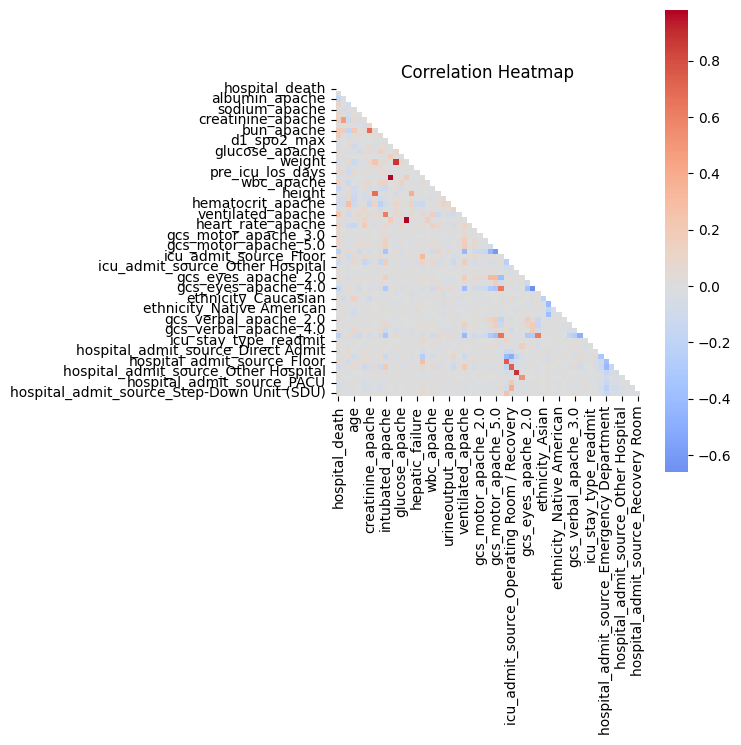

In [ ]:
corr_mtx = processed_df.corr()
mask = np.triu(np.ones_like(corr_mtx, dtype=bool))
plt.figure(figsize=(5, 6))
sns.heatmap(corr_mtx, cmap="coolwarm", mask=mask,center=0, square=True, annot=False)
plt.title("Correlation Heatmap ")
plt.show()

# Model Building

# # RQ 1:

To determine whether machine learning or deep learning models can effectively predict ICU mortality using these early indicators and Identify which features are most influential in the prediction.

In [ ]:
benchmark_df

0        0.10
1        0.47
2        0.00
3        0.04
5        0.05
         ... 
91706    0.01
91708    0.12
91709    0.03
91710    0.05
91711    0.07
Name: benchmark, Length: 67425, dtype: float64

In [ ]:
processed_df, benchmark_df = preprocess_data(source_df.copy() , binary_cols, dummy_columns)

classes = processed_df['hospital_death'].unique()
y = processed_df.pop('hospital_death')
X = processed_df.copy()
X['benchmark'] = benchmark_df
display(X.sample(2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_benchmark = X_train.pop('benchmark')
test_benchmark = X_test.pop('benchmark')
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("y_train value_counts", y_train.value_counts())
print("y_test value_counts", y_test.value_counts())
X_train.shape, X_test.shape, y_train.shape, y_test.shape

,arf_apache,albumin_apache,age,sodium_apache,resprate_apache,creatinine_apache,gender,bun_apache,intubated_apache,d1_spo2_max,...,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other/Unknown,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),benchmark
3004,0.0,3.8,74.0,135.0,4.0,1.08,1,17.0,0.0,99.0,...,1,0,0,0,0,0,0,0,0,0.04
81432,0.0,2.9,68.0,140.0,28.0,0.60,0,7.0,0.0,100.0,...,0,0,0,0,0,0,0,0,0,0.04


y_train value_counts hospital_death
0    49302
1     4638
Name: count, dtype: int64
y_test value_counts hospital_death
0    12326
1     1159
Name: count, dtype: int64


((53940, 58), (13485, 58), (53940,), (13485,))

## LogisticRegression

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred, labels=classes ) )
print(classification_report(y_test, lr_y_pred, labels=classes ))

[[9661 2665]
 [ 280  879]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     12326
           1       0.25      0.76      0.37      1159

    accuracy                           0.78     13485
   macro avg       0.61      0.77      0.62     13485
weighted avg       0.91      0.78      0.83     13485



# Oversampling with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Print class distributions
print("y_train value_counts", y_train_resampled.value_counts())
print("y_test value_counts", y_test.value_counts())

lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_scaled, y_train_resampled)
lr_y_pred = lr.predict(X_test_scaled)

print(confusion_matrix(y_test, lr_y_pred, labels=classes ) )
print(classification_report(y_test, lr_y_pred, labels=classes ))

y_train value_counts hospital_death
0    49302
1    49302
Name: count, dtype: int64
y_test value_counts hospital_death
0    12326
1     1159
Name: count, dtype: int64
[[9613 2713]
 [ 286  873]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     12326
           1       0.24      0.75      0.37      1159

    accuracy                           0.78     13485
   macro avg       0.61      0.77      0.62     13485
weighted avg       0.91      0.78      0.82     13485



## Fine-tunning Paramerters - LogisticRegression

from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

log_reg = LogisticRegression(max_iter=100, random_state=42, class_weight='balanced')

grid_search = GridSearchCV( estimator=log_reg,param_grid=params, scoring='f1', cv=5, verbose=1, n_jobs=-1 )
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params, best_score)

y_pred = grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred, labels=classes ))
print(confusion_matrix(y_test, y_pred, labels=classes ) )

In [ ]:
processed_df, benchmark_df = preprocess_data(source_df.copy() , binary_cols, dummy_columns)

classes = processed_df['hospital_death'].unique()
y = processed_df.pop('hospital_death')
X = processed_df.copy()
X['benchmark'] = benchmark_df
display(X.sample(2))


,arf_apache,albumin_apache,age,sodium_apache,resprate_apache,creatinine_apache,gender,bun_apache,intubated_apache,d1_spo2_max,...,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other/Unknown,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU),benchmark
54026,1.0,2.9,53.0,138.0,11.0,0.98,0,19.0,0.0,100.0,...,1,0,0,0,0,0,0,0,0,0.01
49633,0.0,4.0,47.0,140.0,32.0,0.80,1,10.0,0.0,100.0,...,0,1,0,0,0,0,0,0,0,0.01


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_benchmark = X_train.pop('benchmark')
test_benchmark = X_test.pop('benchmark')

print("y_train value_counts", y_train.value_counts())
print("y_test value_counts", y_test.value_counts())
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print("NaN values before SMOTE:", X_train.isnull().sum().sum())  # Check total NaNs

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
unique_counts = (X_train_resampled.nunique() == 1).sum()
if unique_counts > 0:
    print(f"Warning: {unique_counts} columns have only one unique value. Dropping them.")
    X_train_resampled = X_train_resampled.loc[:, X_train_resampled.nunique() > 1]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.nan_to_num(X_train_scaled)  # Replace NaNs with 0
X_test_scaled = np.nan_to_num(X_test_scaled)  # Replace NaNs with 0
print("y_train value_counts", y_train_resampled.value_counts())
print("y_test value_counts", y_test.value_counts())


scaler1 = StandardScaler()
X_train_scaled1 = scaler1.fit_transform(X_train)
X_test_scaled1 = scaler1.transform(X_test)

X_train_scaled1 = np.nan_to_num(X_train_scaled1)  # Replace NaNs with 0
X_test_scaled1 = np.nan_to_num(X_test_scaled1)  # Replace NaNs with 0


if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print(" NaN or Inf still exists!")
else:
    print("No NaN or Inf values found")

y_train value_counts hospital_death
0    49302
1     4638
Name: count, dtype: int64
y_test value_counts hospital_death
0    12326
1     1159
Name: count, dtype: int64
(53940, 58) (13485, 58) (53940,) (13485,)
NaN values before SMOTE: 0
y_train value_counts hospital_death
0    49302
1    49302
Name: count, dtype: int64
y_test value_counts hospital_death
0    12326
1     1159
Name: count, dtype: int64
No NaN or Inf values found


In [ ]:
print(test_benchmark.shape, X_test_scaled1.shape)

(13485,) (13485, 58)


In [ ]:
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score)
# Calculate scale_pos_weight for imbalance
#num_neg = (y_train == 0).sum()  # Survived
#num_pos = (y_train == 1).sum()  # Death
#scale_pos_weight = num_neg / num_pos
#print(f"scale_pos_weight: {scale_pos_weight:.2f}")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Naive Bayes": GaussianNB()
}

results, results1 = {}, {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Get positive class probabilities

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Store results
    results[name] = {
        "Accuracy": acc,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist(),
        "FPR": fpr.tolist(),  # Store FPR
        "TPR": tpr.tolist(),  # Store TPR
        "ROC AUC": roc_auc
    }

In [ ]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.94       0.94       0.94      12326
   Death (1)      0.36       0.35       0.35       1159

    accuracy                           0.89      13485
   macro avg      0.65       0.64       0.65      13485
weighted avg      0.89       0.89       0.89      13485

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.95      12326
   Death (1)      0.50       0.26       0.34       1159

    accuracy                           0.91      13485
   macro avg      0.72       0.62       0.65      13485
weighted avg      0.90       0.91       0.90      13485

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.95      12326
   Death (1)      0.51       0.30       0.38       1159

    accuracy                           0.91      13485
   macro avg      0.72       0.64       0.67      134

In [ ]:
for name, model in models.items():
    model.fit(X_train_scaled1, y_train)
    y_pred = model.predict(X_test_scaled1)
    y_prob = model.predict_proba(X_test_scaled1)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)


    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results1[name] = {
        "Accuracy": acc,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist(),
        "FPR": fpr.tolist(),
        "TPR": tpr.tolist(),
        "ROC AUC": roc_auc
    }


Logistic Regression
Random Forest
XGBoost
Naive Bayes


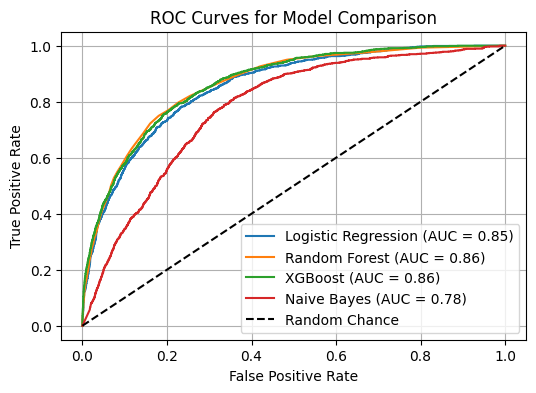

In [ ]:
plot_roc_curves(results1, 'ROC Curves for Model Comparison')

Logistic Regression
Random Forest
XGBoost
Naive Bayes


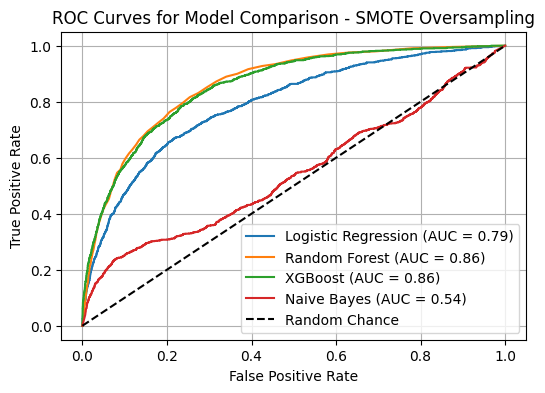

In [ ]:
plot_roc_curves(results, 'ROC Curves for Model Comparison - SMOTE Oversampling')

In [ ]:
print_classification_report(results1)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.97       0.78       0.87      12326
   Death (1)      0.25       0.76       0.37       1159

    accuracy                           0.78      13485
   macro avg      0.61       0.77       0.62      13485
weighted avg      0.91       0.78       0.83      13485

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.92       1.00       0.96      12326
   Death (1)      0.70       0.11       0.19       1159

    accuracy                           0.92      13485
   macro avg      0.81       0.55       0.57      13485
weighted avg      0.90       0.92       0.89      13485

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      12326
   Death (1)      0.58       0.27       0.37       1159

    accuracy                           0.92      13485
   macro avg      0.76       0.63       0.66      134

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_curve, auc
from icumodel import ICUModel, ICUModel_v1, ICUModel_v2, Wide, Deep, SimpleNet
def train_deep_learning_model(dataparcel, icu_model, input_dim, epochs=10, batch_size=8, learning_rate=0.01, val_split=0.2, oversampled=True):
    X_train_scaled, y_train_resampled, X_test_scaled, y_test = dataparcel

    X_train_scaled = np.array(X_train_scaled, dtype=np.float32)
    X_test_scaled = np.array(X_test_scaled, dtype=np.float32)
    y_train_resampled = np.array(y_train_resampled, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    # Handle NaN or infinite values
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled)
    y_train_tensor = torch.tensor(y_train_resampled).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_scaled)
    y_test_tensor = torch.tensor(y_test).unsqueeze(1)

    # Split into training and validation
    train_size = int((1 - val_split) * len(X_train_tensor))
    val_size = len(X_train_tensor) - train_size
    train_dataset, val_dataset = random_split(TensorDataset(X_train_tensor, y_train_tensor), [train_size, val_size])
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Init Dataset --- DONE")
    model = icu_model(input_dim)
    print("Init Model")
    print(model)

    num_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {num_params}")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    #device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(device)
    model.to(device)
    best_val_recall = 0
    early_stopping_counter = 0
    patience = 5  # Stop training if validation recall doesn't improve after 5 epochs

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_preds, val_actuals = [], []
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                probs = torch.sigmoid(outputs)
                predictions = (probs > 0.5).int()
                val_preds.extend(predictions.cpu().numpy())
                val_actuals.extend(y_batch.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_accuracy = accuracy_score(val_actuals, val_preds)
        val_recall = recall_score(val_actuals, val_preds)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val Recall: {val_recall:.4f}")

        # Early stopping based on validation recall
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            best_model = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping if vaildation recall isn't improving ")
                break

    # Load the best model
    model.load_state_dict(best_model)

    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs)
            predictions = (probs > 0.5).int()
            preds.extend(predictions.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(actuals, preds)
    recall = recall_score(actuals, preds)
    report_ = classification_report(actuals, preds, output_dict=True)
    conf_matrix = confusion_matrix(actuals, preds)
    fpr, tpr, _ = roc_curve(actuals, preds)
    roc_auc = auc(fpr, tpr)

    report = {str(int(float(k))) if k.replace('.', '', 1).isdigit() else k: v for k, v in report_.items()}

    model_name = icu_model.__name__
    if oversampled:
        results[model_name] = {
            "Accuracy": accuracy,
            "Precision (Survived 0)": report["0"]["precision"],
            "Recall (Survived 0)": report["0"]["recall"],
            "F1-score (Survived 0)": report["0"]["f1-score"],
            "Precision (Death 1)": report["1"]["precision"],
            "Recall (Death 1)": report["1"]["recall"],
            "F1-score (Death 1)": report["1"]["f1-score"],
            "Confusion Matrix": conf_matrix.tolist(),
            "FPR": fpr.tolist(),  # Store FPR
            "TPR": tpr.tolist(),  # Store TPR
            "ROC AUC": roc_auc
            }
        return results, report_, model
    else:
        results1[model_name] = {
            "Accuracy": accuracy,
            "Precision (Survived 0)": report["0"]["precision"],
            "Recall (Survived 0)": report["0"]["recall"],
            "F1-score (Survived 0)": report["0"]["f1-score"],
            "Precision (Death 1)": report["1"]["precision"],
            "Recall (Death 1)": report["1"]["recall"],
            "F1-score (Death 1)": report["1"]["f1-score"],
            "Confusion Matrix": conf_matrix.tolist(),
            "FPR": fpr.tolist(),  # Store FPR
            "TPR": tpr.tolist(),  # Store TPR
            "ROC AUC": roc_auc
            }
        return results1, report_, model



### Using Oversampling data

In [ ]:
dataparcel = (X_train_scaled, y_train_resampled, X_test_scaled, y_test)

import torch, os
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch.mps
torch.mps.empty_cache()
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

results, ICUModel_report, _ = train_deep_learning_model(dataparcel, ICUModel, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["ICUModel"])  

results, ICUModel_v1_report, _ = train_deep_learning_model(dataparcel, ICUModel_v1, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["ICUModel_v1"])  

In [ ]:
r, r1 = results.copy(), results1.copy()

In [ ]:
results, SimpleNet_report, _ = train_deep_learning_model(dataparcel, SimpleNet , input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["SimpleNet"])

Init Dataset --- DONE
Init Model
SimpleNet(
  (fc1): Linear(in_features=58, out_features=27, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=27, out_features=1, bias=True)
)
Total Parameters: 1621
cpu
Epoch 1/20 - Train Loss: 0.2036, Val Loss: 0.2084, Val Acc: 0.9229, Val Recall: 0.9103
Epoch 2/20 - Train Loss: 0.1936, Val Loss: 0.2016, Val Acc: 0.9255, Val Recall: 0.8953
Epoch 3/20 - Train Loss: 0.1874, Val Loss: 0.1939, Val Acc: 0.9288, Val Recall: 0.9170
Epoch 4/20 - Train Loss: 0.1837, Val Loss: 0.1940, Val Acc: 0.9303, Val Recall: 0.8998
Epoch 5/20 - Train Loss: 0.1817, Val Loss: 0.2008, Val Acc: 0.9302, Val Recall: 0.9037
Epoch 6/20 - Train Loss: 0.1794, Val Loss: 0.1873, Val Acc: 0.9331, Val Recall: 0.9086
Epoch 7/20 - Train Loss: 0.1783, Val Loss: 0.1832, Val Acc: 0.9311, Val Recall: 0.9118
Epoch 8/20 - Train Loss: 0.1775, Val Loss: 0.1876, Val Acc: 0.9306, Val Recall: 0.9164
Early stopping if vaildation recall isn't improving 
{'Accuracy': 0.8923248053392658, 'Precisio

In [ ]:
results, ICUModel_v2_report, _ = train_deep_learning_model(dataparcel, ICUModel_v2, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8,)
print(results["ICUModel_v2"])

Init Dataset --- DONE
Init Model
ICUModel_v2(
  (model): Sequential(
    (0): Linear(in_features=58, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total Parameters: 18369
cpu
Epoch 1/20 - Train Loss: 0.2791, Val Loss: 0.2137, Val Acc: 0.9272, Val Recall: 0.8927
Epoch 2/20 - Train Loss: 0.2519, Val Loss: 0.2138, Val Acc: 0.9265, Val Recall: 0.8789
Epoch 3/20 - Train Loss: 0.2460, Val Loss: 0.2

In [ ]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.94       0.94       0.94      12326
   Death (1)      0.36       0.35       0.35       1159

    accuracy                           0.89      13485
   macro avg      0.65       0.64       0.65      13485
weighted avg      0.89       0.89       0.89      13485

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.95      12326
   Death (1)      0.50       0.26       0.34       1159

    accuracy                           0.91      13485
   macro avg      0.72       0.62       0.65      13485
weighted avg      0.90       0.91       0.90      13485

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.95      12326
   Death (1)      0.51       0.30       0.38       1159

    accuracy                           0.91      13485
   macro avg      0.72       0.64       0.67      134

Logistic Regression
Random Forest
XGBoost
Naive Bayes
SimpleNet
ICUModel_v2


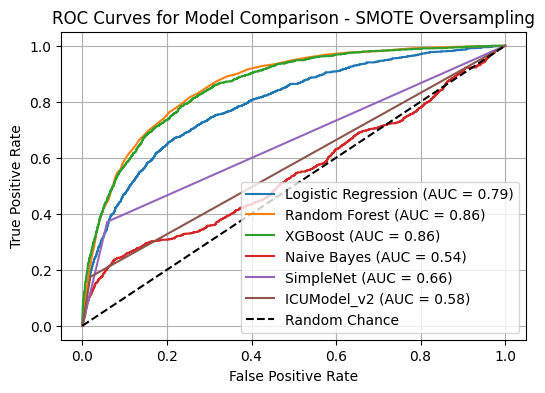

In [ ]:
plot_roc_curves(results, 'ROC Curves for Model Comparison - SMOTE Oversampling')

### Data without Oversampling

results1, Deep_report, _ = train_deep_learning_model(dataparcel, Deep , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(Deep_report)

results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(results["ICUModel"])  

results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel_v1 , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(results["ICUModel_v1"])  

In [ ]:
results1, SimpleNet_report1, save_model1 = train_deep_learning_model(dataparcel, SimpleNet , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8, oversampled=False)
print(results1["SimpleNet"])

Init Dataset --- DONE
Init Model
SimpleNet(
  (fc1): Linear(in_features=58, out_features=27, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=27, out_features=1, bias=True)
)
Total Parameters: 1621
cpu
Epoch 1/30 - Train Loss: 0.2063, Val Loss: 0.1915, Val Acc: 0.9270, Val Recall: 0.9111
Epoch 2/30 - Train Loss: 0.1925, Val Loss: 0.1923, Val Acc: 0.9269, Val Recall: 0.9117
Epoch 3/30 - Train Loss: 0.1856, Val Loss: 0.1868, Val Acc: 0.9280, Val Recall: 0.9093
Epoch 4/30 - Train Loss: 0.1837, Val Loss: 0.1794, Val Acc: 0.9303, Val Recall: 0.9099
Epoch 5/30 - Train Loss: 0.1816, Val Loss: 0.1822, Val Acc: 0.9309, Val Recall: 0.9154
Epoch 6/30 - Train Loss: 0.1808, Val Loss: 0.1809, Val Acc: 0.9329, Val Recall: 0.9138
Epoch 7/30 - Train Loss: 0.1788, Val Loss: 0.1770, Val Acc: 0.9320, Val Recall: 0.9139
Epoch 8/30 - Train Loss: 0.1777, Val Loss: 0.1835, Val Acc: 0.9343, Val Recall: 0.9035
Epoch 9/30 - Train Loss: 0.1777, Val Loss: 0.1869, Val Acc: 0.9304, Val Recall: 0.9197
Epoch 10

In [ ]:
results1, ICUModel_v2_report1, save_model1 = train_deep_learning_model(dataparcel, ICUModel_v2 , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8, oversampled=False)
print(results1["ICUModel_v2"])

Init Dataset --- DONE
Init Model
ICUModel_v2(
  (model): Sequential(
    (0): Linear(in_features=58, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total Parameters: 18369
cpu
Epoch 1/30 - Train Loss: 0.2769, Val Loss: 0.2161, Val Acc: 0.9236, Val Recall: 0.8934
Epoch 2/30 - Train Loss: 0.2499, Val Loss: 0.2628, Val Acc: 0.9234, Val Recall: 0.8723
Epoch 3/30 - Train Loss: 0.2439, Val Loss: 0.2


# # RQ 2:

How does model performance compare to traditional clinical scoring systems (apache_4a_hospital_death_prob, apache_4a_icu_death_prob) for ICU mortality prediction?

### APACHE Report

=> extract relevent information from APACHE report for benchmark

In [ ]:
test_benchmark

84319     NaN
26798    0.09
84646    0.01
47981    0.04
19799    0.01
         ... 
58531    0.01
18607    0.01
83646    0.03
83654    0.03
88484    0.24
Name: benchmark, Length: 13485, dtype: float64

In [ ]:
test_benchmark = test_benchmark.fillna(0.5) # IMPUTE Nan to imply borderline assumption
train_benchmark_binary = train_benchmark.apply(lambda x: 1 if x > 0.5 else 0)
test_benchmark_binary = test_benchmark.apply(lambda x: 1 if x > 0.5 else 0)
test_benchmark_binary.value_counts()

benchmark
0    12917
1      568
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, test_benchmark_binary)
report_ = classification_report(y_test, test_benchmark_binary, output_dict=True)
conf_matrix = confusion_matrix(y_test, test_benchmark_binary)
fpr, tpr, _ = roc_curve(y_test, test_benchmark)
roc_auc = auc(fpr, tpr)
model_name = "Benchmark"
report = {str(int(float(k))) if k.replace('.', '', 1).isdigit() else k: v for k, v in report_.items()}

results[model_name] = {
    "Accuracy": accuracy,
    "Precision (Survived 0)": report["0"]["precision"],
    "Recall (Survived 0)": report["0"]["recall"],
    "F1-score (Survived 0)": report["0"]["f1-score"],
    "Precision (Death 1)": report["1"]["precision"],
    "Recall (Death 1)": report["1"]["recall"],
    "F1-score (Death 1)": report["1"]["f1-score"],
    "Confusion Matrix": conf_matrix.tolist(),
    "FPR": fpr.tolist(),  # Store FPR
    "TPR": tpr.tolist(),  # Store TPR
    "ROC AUC": roc_auc
    }
results1[model_name] = {
    "Accuracy": accuracy,
    "Precision (Survived 0)": report["0"]["precision"],
    "Recall (Survived 0)": report["0"]["recall"],
    "F1-score (Survived 0)": report["0"]["f1-score"],
    "Precision (Death 1)": report["1"]["precision"],
    "Recall (Death 1)": report["1"]["recall"],
    "F1-score (Death 1)": report["1"]["f1-score"],
    "Confusion Matrix": conf_matrix.tolist(),
    "FPR": fpr.tolist(),  # Store FPR
    "TPR": tpr.tolist(),  # Store TPR
    "ROC AUC": roc_auc
        }

Logistic Regression
Random Forest
XGBoost
Naive Bayes
SimpleNet
ICUModel_v2
Benchmark


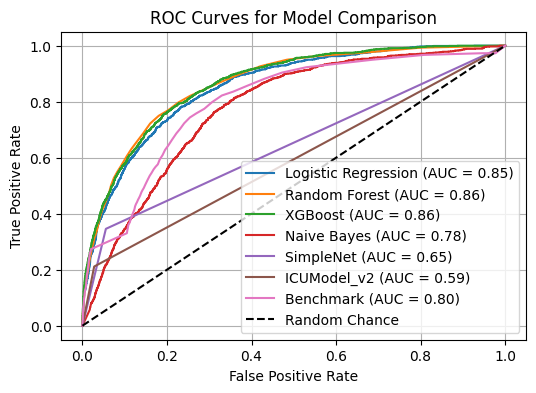

In [ ]:
plot_roc_curves(results1, 'ROC Curves for Model Comparison')

Logistic Regression
Random Forest
XGBoost
Naive Bayes
SimpleNet
ICUModel_v2
Benchmark


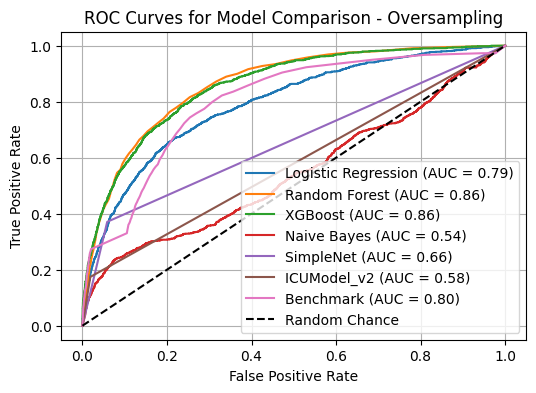

In [ ]:
plot_roc_curves(results, 'ROC Curves for Model Comparison - Oversampling')

In [ ]:
print_classification_report(results1)
#Model Comparison


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.97       0.78       0.87      12326
   Death (1)      0.25       0.76       0.37       1159

    accuracy                           0.78      13485
   macro avg      0.61       0.77       0.62      13485
weighted avg      0.91       0.78       0.83      13485

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.92       1.00       0.96      12326
   Death (1)      0.70       0.11       0.19       1159

    accuracy                           0.92      13485
   macro avg      0.81       0.55       0.57      13485
weighted avg      0.90       0.92       0.89      13485

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      12326
   Death (1)      0.58       0.27       0.37       1159

    accuracy                           0.92      13485
   macro avg      0.76       0.63       0.66      134

In [ ]:
print_classification_report(results)
#Model Comparison - Oversampling


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.94       0.94       0.94      12326
   Death (1)      0.36       0.35       0.35       1159

    accuracy                           0.89      13485
   macro avg      0.65       0.64       0.65      13485
weighted avg      0.89       0.89       0.89      13485

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.95      12326
   Death (1)      0.50       0.26       0.34       1159

    accuracy                           0.91      13485
   macro avg      0.72       0.62       0.65      13485
weighted avg      0.90       0.91       0.90      13485

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.95      12326
   Death (1)      0.51       0.30       0.38       1159

    accuracy                           0.91      13485
   macro avg      0.72       0.64       0.67      134

results1.pop('Naive Bayes')
results.pop('Naive Bayes')

plot_roc_curves(results, 'ROC Curves for Model Comparison - Oversampling')

plot_roc_curves(results, 'ROC Curves for Model Comparison')

=> Best Overall Performance	XGBoost or Random Forest
Random Forest (0.86 AUC, 91% accuracy)
XGBoost (0.86 AUC, 91% accuracy)
Benchmark Model (0.80 AUC, 92% accuracy)

=> Best for Detecting Death Cases	XGBoost (Oversampling)
Random Forest with Oversampling (F1-score 0.33, Recall 25%) improved recall.
XGBoost with Oversampling (F1-score 0.38, Recall 30%) is better than without oversampling.
SimpleNet (F1-score 0.37, Recall 34%) performed better than ICUModel_v2.

=> Best Balance of Precision & Recall	Benchmark Model

=> Naive Bayes fails with oversampling (AUC drops significantly)
=> Random Forest and XGBoost handle oversampling well and improve minority class recall


XGBoost remains the best performing model overall, with the highest AUC (0.86) and a decent balance between recall and precision.
